In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)

PROJECT_ROOT: d:\College\glaucoma-detection-project


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    recall_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

sns.set_theme(style="whitegrid")

In [3]:
features_path = os.path.join(
    PROJECT_ROOT, "outputs", "metrics", "features_g1020.csv"
)

df = pd.read_csv(features_path)

print("Split distribution:")
print(df["split"].value_counts())

print("\nLabel distribution:")
print(df["label"].value_counts())

Split distribution:
split
training    816
testing     204
Name: count, dtype: int64

Label distribution:
label
0    724
1    296
Name: count, dtype: int64


In [4]:
feature_cols = ["mean_r", "mean_g", "mean_b", "lbp_mean"]

X_train = df[df.split == "training"][feature_cols]
y_train = df[df.split == "training"]["label"]

X_test = df[df.split == "testing"][feature_cols]
y_test = df[df.split == "testing"]["label"]

print("Train:", X_train.shape)
print("Test:", X_test.shape)

Train: (816, 4)
Test: (204, 4)


In [5]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Logistic Regression

In [6]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

In [7]:
def evaluate_model(name, y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    
    sensitivity = recall_score(y_true, y_pred)  # Recall for class 1
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    print(f"\n{name}")
    print("Accuracy:", round(acc, 4))
    print("ROC-AUC:", round(auc, 4))
    print("Sensitivity (Recall):", round(sensitivity, 4))
    print("Specificity:", round(specificity, 4))
    
    return acc, auc, sensitivity, specificity

In [8]:
acc_lr, auc_lr, sens_lr, spec_lr = evaluate_model(
    "Logistic Regression",
    y_test,
    y_pred_lr,
    y_prob_lr
)


Logistic Regression
Accuracy: 0.4804
ROC-AUC: 0.4966
Sensitivity (Recall): 0.4915
Specificity: 0.4759


SVM

In [9]:
svm = SVC(
    probability=True,
    class_weight="balanced"
)

svm.fit(X_train_scaled, y_train)

y_pred_svm = svm.predict(X_test_scaled)
y_prob_svm = svm.predict_proba(X_test_scaled)[:, 1]

acc_svm, auc_svm, sens_svm, spec_svm = evaluate_model(
    "SVM",
    y_test,
    y_pred_svm,
    y_prob_svm
)


SVM
Accuracy: 0.5637
ROC-AUC: 0.4528
Sensitivity (Recall): 0.4576
Specificity: 0.6069


Random Forest

In [10]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

acc_rf, auc_rf, sens_rf, spec_rf = evaluate_model(
    "Random Forest",
    y_test,
    y_pred_rf,
    y_prob_rf
)


Random Forest
Accuracy: 0.6814
ROC-AUC: 0.5595
Sensitivity (Recall): 0.0678
Specificity: 0.931


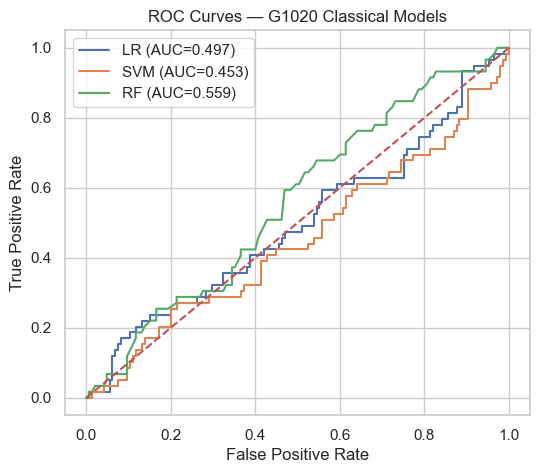

In [11]:
plt.figure(figsize=(6,5))

for name, y_prob in [
    ("LR", y_prob_lr),
    ("SVM", y_prob_svm),
    ("RF", y_prob_rf)
]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1], [0,1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — G1020 Classical Models")
plt.legend()

os.makedirs("outputs/figures/phase4", exist_ok=True)
plt.savefig("outputs/figures/phase4/g1020_classical_roc.png")
plt.show()

In [12]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM", "Random Forest"],
    "Accuracy": [acc_lr, acc_svm, acc_rf],
    "ROC-AUC": [auc_lr, auc_svm, auc_rf],
    "Sensitivity": [sens_lr, sens_svm, sens_rf],
    "Specificity": [spec_lr, spec_svm, spec_rf]
})

results

,Model,Accuracy,ROC-AUC,Sensitivity,Specificity
0,Logistic Regression,0.480392,0.496552,0.491525,0.475862
1,SVM,0.563725,0.452835,0.457627,0.606897
2,Random Forest,0.681373,0.559497,0.067797,0.931034


In [14]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.10.0+cpu
None
